In [1]:
import sys 
sys.path.append('..')

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
from numpy import trapz

In [3]:
min_temp = pd.read_excel('../input/MinClimate.xlsx', sheet_name='Temp')
min_prec = pd.read_excel('../input/MinClimate.xlsx', sheet_name='Prec')
a_classified = pd.read_excel('../input/quotient_deviation_df_A_CLASSIFIED.xlsx')
b_classified = pd.read_excel('../input/quotient_deviation_df_B_CLASSIFIED_FIXED.xlsx')

In [4]:
monthly_temp = pd.DataFrame({'Year':list(min_temp.columns[2:])})
monthly_prec = pd.DataFrame({'Year':list(min_prec.columns[2:])})

months_names = ['', 'January', 'February', 'March',
                'April', 'May', 'June', 'July',
                'August', 'September', 'October',
                'November', 'December']

for i in range(1,13):
    monthly_temp[months_names[i]] = list(min_temp[min_temp['Month']==i].mean(skipna=True)[2:])
    monthly_prec[months_names[i]] = list(min_prec[min_prec['Month']==i].sum(skipna=True)[2:])

In [5]:
from utils.functions import get_moving_avg, get_moving_sum, list_to_cumulative

In [48]:
first_day = 91 +30 #, +44, +61
last_day = -61 -31

temp_df = get_moving_avg(min_temp)[first_day:last_day].reset_index(drop=True)

scaled_temp_df = (temp_df - min(temp_df.min()[2:])) / (max(temp_df.max()[2:]) - min(temp_df.min()[2:]))
scaled_temp_df['Month'] = temp_df['Month']
scaled_temp_df['Day'] = temp_df['Day']

cum_prec = {
    'Month': list(min_prec['Month']),
    'Day': list(min_prec['Day'])
}
for column in min_prec.columns:
    if column in ['Day', 'Month']:
        continue
    cum_prec[column] = list_to_cumulative(min_prec[column])
cum_prec = pd.DataFrame(cum_prec)

prec_df = get_moving_avg(cum_prec)[first_day:last_day].reset_index(drop=True)
scaled_prec_df = (prec_df - min(prec_df.min()[2:])) / (max(prec_df.max()[2:]) - min(prec_df.min()[2:]))
scaled_prec_df['Month'] = prec_df['Month']
scaled_prec_df['Day'] = prec_df['Day']

areas = abs(scaled_temp_df - scaled_prec_df).drop(columns=['Month', 'Day']).sum()

In [72]:
areas_df = pd.DataFrame(areas).reset_index().rename(columns={0:'Area', 'index':'Year'})
areas_df = a_classified[['Year', 'Class 4']].merge(areas_df, how='right', on='Year')
areas_df = areas_df.drop(areas_df[areas_df['Area'] == 0].index).reset_index(drop=True)

In [124]:
areas_df = pd.DataFrame(areas).reset_index().rename(columns={0:'Area', 'index':'Year'})
areas_df = a_classified[['Year', 'Class 4']].merge(areas_df, how='right', on='Year')

In [186]:
import numpy as np
import pandas as pd


def get_median_index(df: pd.DataFrame):
    ranks = df.rank(pct=True)
    close_to_median = abs(ranks - 0.5)
    return close_to_median.idxmin()


C:\Users\Mikhail\AppData\Local\Temp/ipykernel_25580/2295265864.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['Year'] = [2000 for _ in range(len(date_df))]


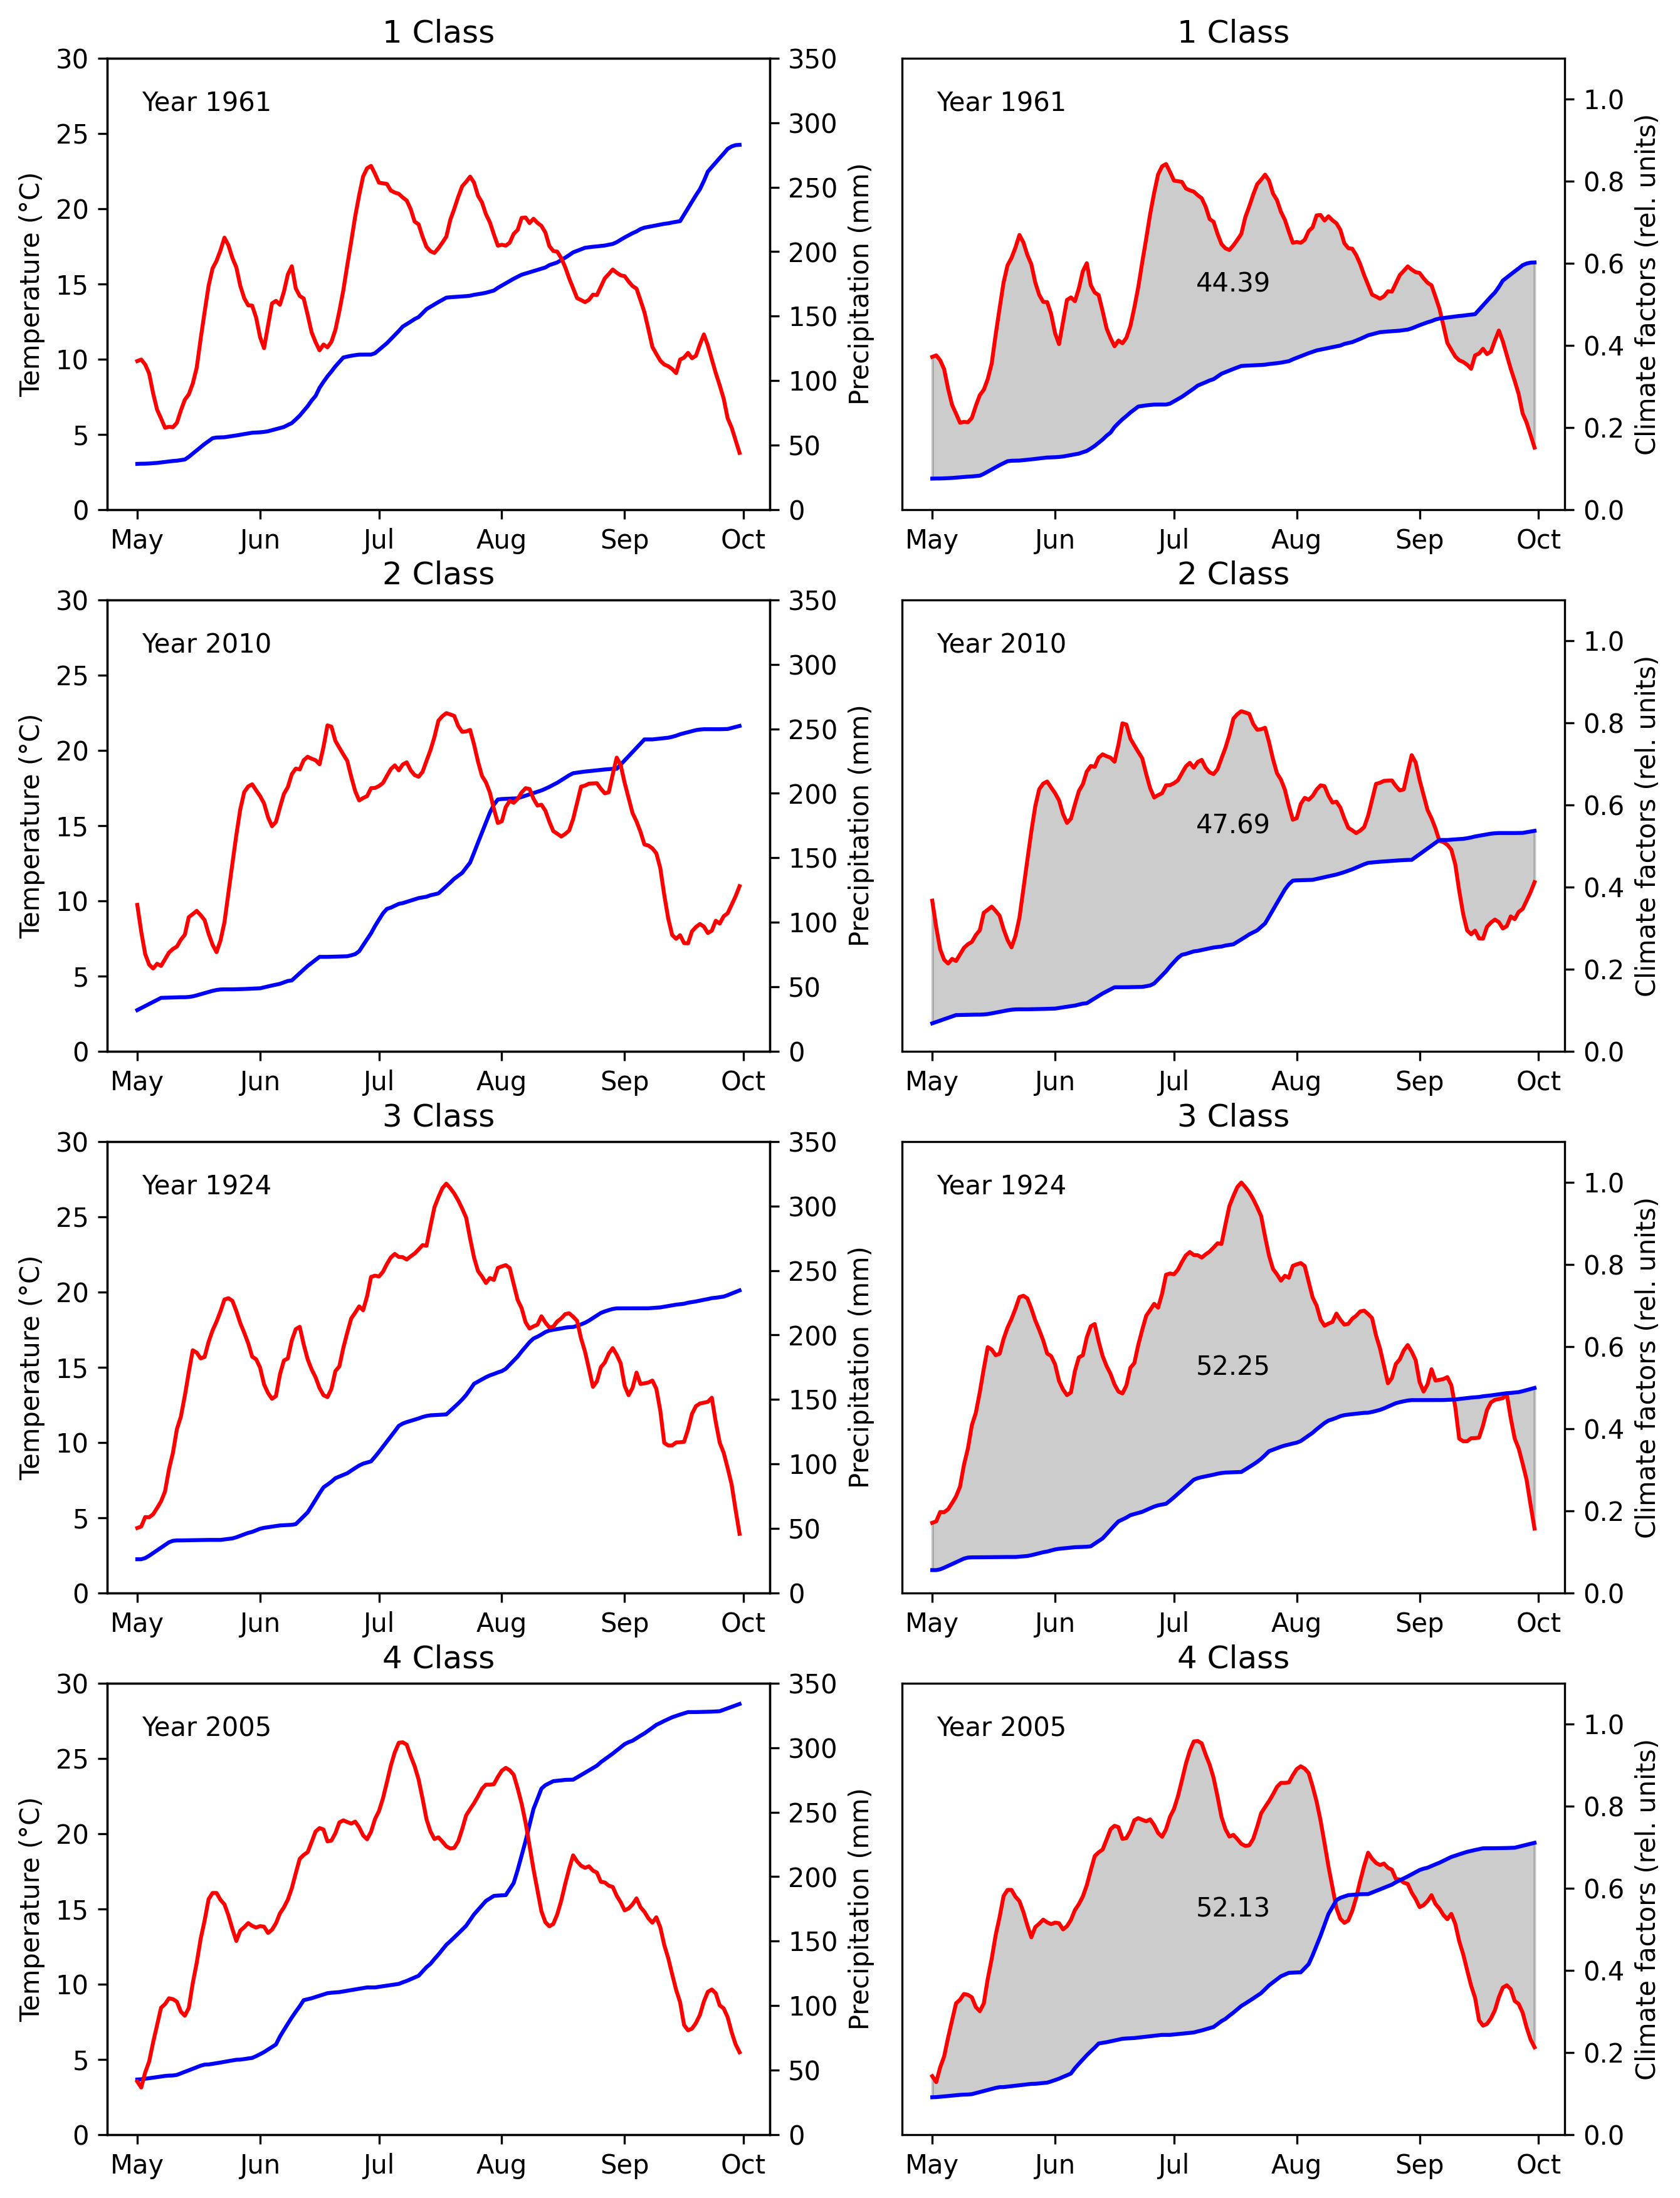

In [249]:
first_day = 91 +30 #, +44, +61
last_day = -61 -31

date_df = min_temp[['Month', 'Day']]
date_df['Year'] = [2000 for _ in range(len(date_df))]
x = pd.to_datetime(date_df)[first_day:last_day]

fig, ax = plt.subplots(nrows=4, ncols=2, dpi=300, figsize=(10, 12))
plt.subplots_adjust(bottom=0.03, top=0.95)
min_temp_moving_avg = get_moving_avg(min_temp).iloc[first_day:last_day].drop(columns=['Month', 'Day']).reset_index(drop=True)
min_prec_moving_avg_cumsum = get_moving_avg(min_prec.fillna(0).cumsum()).drop(columns=['Month', 'Day']).iloc[first_day:last_day].reset_index(drop=True)


temp_max = min_temp_moving_avg.max().max()
prec_max = min_prec_moving_avg_cumsum.max().max()
temp_min = min_temp_moving_avg.min().min()
prec_min = min_prec_moving_avg_cumsum.min().min()

scaled_min_temps = (min_temp_moving_avg - temp_min) / (temp_max - temp_min)
scaled_min_precs =  (min_prec_moving_avg_cumsum- prec_min) / (prec_max - prec_min)


for i in range(4):
    selected = areas_df[areas_df['Class 4'] == i]
    median_year_index = selected.apply(get_median_index, 0)['Area']
    median_year = int(selected.loc[median_year_index]['Year'])

    y_temp = min_temp_moving_avg[median_year]
    y_prec = min_prec_moving_avg_cumsum[median_year]
    y_temp_sc = scaled_min_temps[median_year]
    y_prec_sc = scaled_min_precs[median_year]

    ax[i, 0].plot(x, y_temp, color='red')
    
    ax2 = ax[i, 0].twinx()
    ax2.plot(x, y_prec, color='blue')

    ax[i, 1].plot(x, y_temp_sc, c='red')
    ax[i, 1].plot(x, y_prec_sc, c='blue')
    ax[i, 1].fill_between(x, y_temp_sc, y_prec_sc, color='black', alpha=0.2)

    ax2.set_ylim([0, 350])
    
    ax[i, 0].set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Precipitation (mm)')
    ax[i, 0].set_zorder(1)  # default zorder is 0 for ax1 and ax2
    ax[i, 0].patch.set_visible(False)  # prevents ax1 from hiding ax2

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[i, 0].xaxis.set_major_locator(locator)
    ax[i, 0].xaxis.set_major_formatter(formatter)
    ax[i, 1].xaxis.set_major_locator(locator)
    ax[i, 1].xaxis.set_major_formatter(formatter)
    #ax.set_xlim([date(2000, 4, 1), date(2000, 10, 30)])
    ax[i, 0].set_ylim([0, 30])
    ax[i, 1].set_ylim([0, 1.1])

    ax[i, 0].set_title(f'{i+1} Class')
    ax[i, 1].set_title(f'{i+1} Class')
    ax[i, 1].set_ylabel('Climate factors (rel. units)')
    ax[i, 1].yaxis.set_label_position("right")

    ax[i, 1].yaxis.tick_right()

    loc_area = sum(abs(y_temp_sc - y_prec_sc))
    ax[i, 0].text(0.15, 0.9, f'Year {median_year}', horizontalalignment='center', verticalalignment='center', transform=ax[i, 0].transAxes)
    ax[i, 1].text(0.15, 0.9, f'Year {median_year}', horizontalalignment='center', verticalalignment='center', transform=ax[i, 1].transAxes)
    ax[i, 1].text(0.5, 0.5, f'{loc_area:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax[i, 1].transAxes)


# Area calulating for every year

In [33]:
first_day = 91 +30 # +14  +44 +61 
last_day = -61 -31

In [34]:
temp_df = get_moving_avg(min_temp)[first_day:last_day].reset_index(drop=True)

scaled_temp_df = (temp_df - min(temp_df.min()[2:])) / (max(temp_df.max()[2:]) - min(temp_df.min()[2:]))
scaled_temp_df['Month'] = temp_df['Month']
scaled_temp_df['Day'] = temp_df['Day']

In [35]:
cum_prec = {
    'Month': list(min_prec['Month']),
    'Day': list(min_prec['Day'])
}
for column in min_prec.columns:
    if column in ['Day', 'Month']:
        continue
    cum_prec[column] = list_to_cumulative(min_prec[column])
cum_prec = pd.DataFrame(cum_prec)

In [36]:
prec_df = get_moving_avg(cum_prec)[first_day:last_day].reset_index(drop=True)
scaled_prec_df = (prec_df - min(prec_df.min()[2:])) / (max(prec_df.max()[2:]) - min(prec_df.min()[2:]))
scaled_prec_df['Month'] = prec_df['Month']
scaled_prec_df['Day'] = prec_df['Day']

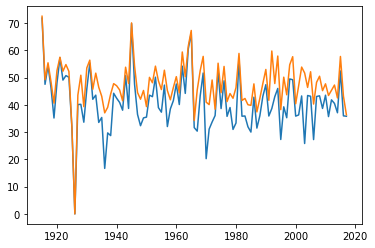

In [37]:
ind = scaled_temp_df > scaled_prec_df
plt.plot(abs(scaled_temp_df[ind] - scaled_prec_df[ind]).sum()[2:])
plt.plot(abs(scaled_temp_df - scaled_prec_df).sum()[2:])

In [40]:
import numpy as np

In [ ]:
47.00458974674386

In [47]:
abs(scaled_temp_df - scaled_prec_df).drop(columns=['Month', 'Day']).sum() == 47.00458974674386

1915    False
1916    False
1917    False
1918    False
1919    False
        ...  
2013    False
2014    False
2015    False
2016    False
2017    False
Length: 103, dtype: bool

In [43]:
np.median(abs(scaled_temp_df - scaled_prec_df).drop(columns=['Month', 'Day']).sum())

47.00458974674386

In [15]:
pd.DataFrame(abs(scaled_temp_df - scaled_prec_df).sum()).to_excel('../output/to_send/NEW_AREA.xlsx')

In [23]:
areas = []

for column in scaled_prec_df.columns:
    if column in ['Day', 'Month']:
        continue
    a = find_area_between_temp_prec(scaled_temp_df[column], scaled_prec_df[column], False)
    areas += [ a if a != 0 else np.nan]

----------------

In [24]:
areas_df = {'Year': scaled_prec_df.columns[2:], 'Area':areas}

In [91]:
areas_df['Area May_1st'] = areas

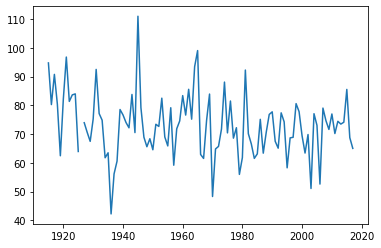

In [56]:
plt.plot(scaled_prec_df.columns[2:], areas)

In [57]:
pd.DataFrame().to_csv('../output/Year_Areas_difference_fixed.csv', index=False)

In [16]:
pd.DataFrame(areas_df).to_excel('../output/Year_Areas_EXPERIMENT.xlsx', index=False)

In [26]:
pd.DataFrame(areas_df)

,Year,Area
0,1915,72.475363
1,1916,49.191596
2,1917,55.405994
3,1918,48.456896
4,1919,NaN
...,...,...
98,2013,47.249483
99,2014,42.531646
100,2015,57.727728
101,2016,43.218554


In [251]:
-61 -31

-92